# Tutorial - Quantum kernel estimation with application to disability insurance

B. Djehiche and B. Löfdahl – KTH, Department of Mathematics / SEB –
Risks 2021, 9(12), 216; https://doi.org/10.3390/risks9120216

Hands-on assistance: [Anastasiia Andriievska](https://www.linkedin.com/in/aandriievska/)

In [1]:
!pip install qrisp==0.7.9 pandas numpy matplotlib scikit-learn sympy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.0/748.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=62772e19cea7fb5b2eb6b8cc44247952e5037b479b9be403410cd411245f3cd0
  Stored in directory: /root/.cache/pip/wheels/af/02/71/aae0f7ee738abf19498353918ddae0f90a0d6ceb337b0bbc91
Successfully built tdqm
  Attempting uninstall: sympy
    Found existing installatio

In [2]:
# install necessary packages via pip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from copy import copy
from qrisp import QuantumVariable, QuantumCircuit
from sympy import symbols

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


First, we create some synthetic data. The x-variable holds the available data. x[i][0] represents gender (0 or 1). x[i][1] represents age, normalized to the [0,1] interval. The y-variable is the value that we seek to model. It represents the logistic transition probability between two states. The w-variable represents the weight that we assign to each data point.

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples per gender
nsamp = 100

# Create feature matrix: gender (0 or 1), normalized age [0, 1]
x = np.array([[0.0, i/nsamp] for i in range(nsamp)] + [[1.0, i/nsamp] for i in range(nsamp)])

# Generate target values with noise
y = np.array([
    -4.5 + 0.2*a[0]*(1 - 5*a[1]**2) + a[1]*(1 + a[0]*0.2) + 0.1*np.random.normal()
    for a in x
])

# Logistic transformation
p = 1 / (1 + np.exp(-y))

# Population size based on age
n = [
    int(2000 + 6000*xj[1]/0.7) if xj[1] <= 0.7 else int(8000 - 3000*(xj[1] - 0.7)/0.3)
    for xj in x
]

# Weighted transitions
d = [nj * pj for nj, pj in zip(n, p)]

We can use the Pandas library to create a DataFrame and then save it as a CSV file, which support column headers. This will create a CSV file with each column labeled as ‘gender’, ‘age group (normalized)’, ‘population size’, and ‘number of transitions’ respectively. The index=False argument is used to prevent pandas from writing row indices into the file.

In [4]:
# Create a DataFrame
df = pd.DataFrame({
    'gender': [a[0] for a in x],
    'age group (normalized)': [a[1] for a in x],
    'population size': n,
    'number of transitions': [int(round(a)) for a in d]
})

# Write the DataFrame to a CSV file
df.to_csv('fdata.csv', index=False)  # index=False argument is used to prevent pandas from writing row indices into the CSV file

One can read the data back from the file like this:

In [5]:
data = pd.read_csv('fdata.csv')

### Transform and inspect data

In [6]:
x = np.array( [[a,b] for a,b in zip(data['gender'], data['age group (normalized)'])] )
print(x[0:10])

[[0.   0.  ]
 [0.   0.01]
 [0.   0.02]
 [0.   0.03]
 [0.   0.04]
 [0.   0.05]
 [0.   0.06]
 [0.   0.07]
 [0.   0.08]
 [0.   0.09]]


In [7]:
y[0:10]

array([-4.45032858, -4.50382643, -4.41523115, -4.31769701, -4.48341534,
       -4.4734137 , -4.28207872, -4.35325653, -4.46694744, -4.355744  ])

In [8]:
# raw transition frequency per group, used for plots
p_raw = [a/b for a,b in zip(d,n)]

# logistic probability, used as input to SVR optimization
y = np.array([np.log( p / (1-p) ) for p in p_raw])

# calculate weights for SVR based on population size
w = np.array([1./nj for nj in n])

# normalize weights (equivalent to changing the hyperparameters of the SVR)
w = w/sum(w)*len(x)

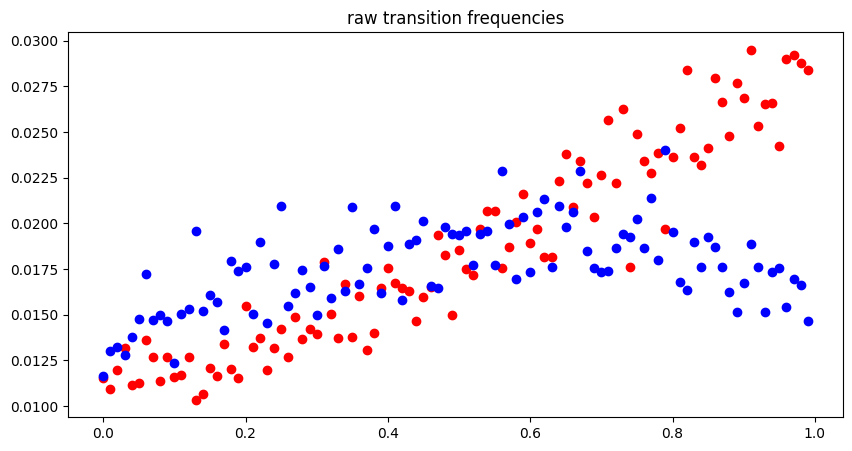

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot([xj[1] for xj,p in zip(x, p_raw) if xj[0] == 0], [p for xj,p in zip(x, p_raw) if xj[0] == 0], 'or')
axs.plot([xj[1] for xj,p in zip(x, p_raw) if xj[0] == 1], [p for xj,p in zip(x, p_raw) if xj[0] == 1], 'ob')
axs.set_title("raw transition frequencies")
plt.show()

The first step of the modelling is to define the mapping from data space to our quantum feature space. This is done by setting up the build_feature_map function. The circuit below is a very simplified two-variable circuit. Feel free to experiment!

In [10]:
from qrisp import ry

# Define a simple feature map using Ry rotations
def build_feature_map(sym):
    n = 2  # Number of qubits
    q = QuantumVariable(n)
    params = symbols(sym + ':' + str(n))  # Create symbolic parameters: x:0, x:1
    ry(np.pi * params[0], q[0])  # Apply Ry rotation to qubit 0
    ry(np.pi * params[1], q[1])  # Apply Ry rotation to qubit 1
    return q

# Build the feature map
feature_map = build_feature_map('x')

# Inspect the quantum state
print(feature_map.qs)


QuantumCircuit:
---------------
     ┌──────────┐
q.0: ┤ Ry(π*x0) ├
     ├──────────┤
q.1: ┤ Ry(π*x1) ├
     └──────────┘
Live QuantumVariables:
----------------------
QuantumVariable q


In [11]:
# example, assign random data as parameters and print cirquit

subs_dic = {a : np.random.rand() for a in feature_map.qs.abstract_params}
bound_qc = feature_map.qs.bind_parameters(subs_dic)
print(bound_qc)

     ┌────────────┐
q.0: ┤ Ry(2.3272) ├
     ├────────────┤
q.1: ┤ Ry(2.7563) ├
     └────────────┘


For a data pair $(x, y)$, we create the kernel circuit by calling the build_feature_map twice, once for $x$ and once for $y$, inverting the latter, and joining them together

In [12]:
kernel = build_feature_map('x')
y_inverse = build_feature_map('y').qs.inverse()

kernel.qs.append(y_inverse.to_op(), kernel.qs.qubits)

kernel.qs.measure(kernel.qs.qubits)

print(kernel.qs.transpile())

      ┌──────────┐┌─────────────┐┌─┐   
 q.0: ┤ Ry(π*x0) ├┤ Ry((-π)*y0) ├┤M├───
      ├──────────┤├─────────────┤└╥┘┌─┐
 q.1: ┤ Ry(π*x1) ├┤ Ry((-π)*y1) ├─╫─┤M├
      └──────────┘└─────────────┘ ║ └╥┘
cb_0: ════════════════════════════╩══╬═
                                     ║ 
cb_1: ═══════════════════════════════╩═
                                       


## Experimenting

Remember, when experimenting with quantum circuits, it's important to understand what each gate does and how changing the circuit might affect your results. Happy experimenting! 😊

A few general guidelines for experimenting with quantum circuits:

1. **Understand the problem**: Before you start experimenting, make sure you understand the problem you're trying to solve and how a quantum circuit could help solve it.

2. **Start simple**: Start with a simple circuit and gradually add complexity. This makes it easier to understand what each part of your circuit is doing.

3. **Use a variety of gates**: Different gates can have different effects on your quantum state, so try using a variety of gates in your experiments.

4. **Test on a simulator first**: Before running your circuit on a real quantum computer, test it on a simulator to make sure it's working as expected.

5. **Analyze your results**: After running your circuit, analyze the results to see if they make sense and if they're helping you solve your problem.

6. **Iterate**: Experimenting with quantum circuits often involves a lot of trial and error. Don't be afraid to iterate on your design and try new things.

In the context of the Quantum Support Vector Regression (QSVR) for disability insurance that you're working on, you might want to experiment with different ways of encoding your data into the quantum state or different types of quantum kernels. Remember, the goal is to find a quantum circuit that can effectively model your data and help you make accurate predictions.

### Exercise 1 – Experimenting with Quantum Feature Maps

🧪 Goal:
Explore how different quantum circuit designs affect the feature mapping in quantum kernel estimation.

#####1.1 Change the rotation gates
Try replacing ry with other single-qubit gates like rx, rz, or combinations:

In [ ]:
from qrisp import rx, rz
rx(np.pi * params[0], q[0])
rz(np.pi * params[1], q[1])

What to observe:

How does the circuit look after transpiling?
Does the kernel matrix change significantly?
Does SVR performance improve or degrade?

1.2 Add entanglement
Introduce gates like cx or cz to create entanglement between qubits:

In [ ]:
from qrisp import cx, h
h(q[0])
cx(q[0], q[1])

What to observe:

Does entanglement improve the expressiveness of the kernel?
Is the circuit still efficient to simulate?

1.3 Use nonlinear parameter functions
Instead of linear scaling, try nonlinear transformations:

In [ ]:
ry(np.sin(params[0] * np.pi), q[0])
ry(np.log1p(params[1]) * np.pi, q[1])

What to observe:

Does the kernel matrix capture more subtle patterns?
Are the results more stable or more sensitive?

1.4 Increase the number of qubits
Modify n = 2 to n = 3 or more, and expand your feature map accordingly.

What to observe:

How does the circuit scale?
Does the SVR model benefit from higher-dimensional quantum features?

#### Hints
1. Use .transpile() to inspect how your circuit changes.
2. Try binding real data instead of random values to see how the circuit behaves.
3. Consider how each change might affect the kernel similarity between data points.

In [ ]:
# Test code here
# Then rerun the following cells



#### Estimating the kernel matrix

The train_kernel_matrix function prepares the kernel estimation by setting up inner product circuits, based on each combination of two data points. The kernel circuits are then run on a either a specified backend, or using statevector simulation.

In [13]:
def train_kernel_matrix(x, f_feature_map, shots=1000, backend=None):
    # Build base kernel circuit
    kernel = f_feature_map('x')
    x_params = copy(kernel.qs.abstract_params)

    # Build inverse feature map for y
    adjoint_qs = f_feature_map('y').qs.inverse()
    y_params = adjoint_qs.abstract_params
    # Combine circuits
    kernel.qs.append(adjoint_qs.to_op(), kernel.qs.qubits)
    kernel.qs = kernel.qs.transpile()

    # Add measurement if using backend
    if backend is not None:
        kernel.qs.measure(kernel.qs.qubits)

    # Initialize kernel matrix
    n = len(x)
    K = np.eye(n)

    # Loop over all pairs (i, j)
    for i in range(n):
        subs_dic = {p: x[i][int(p.name[1:])] for p in x_params}
        for j in range(i + 1, n):
            for p in y_params:
                subs_dic[p] = x[j][int(p.name[1:])]

            # Bind parameters
            bound_kernel = kernel.qs.bind_parameters(subs_dic)

            # Run circuit
            if backend is not None:
                res = bound_kernel.run(shots=shots, backend=backend)
                K_ij = res.get('0' * len(kernel.qs.qubits), 0) / shots
            else:
                res = bound_kernel.statevector_array()
                K_ij = np.abs(res[0]) ** 2

            # Fill symmetric matrix
            K[i, j] = K[j, i] = K_ij

    return K

We evaluate the kernel matrix based on our $x$ data and the build_feature_map helper function.

In [14]:
matrix_train = train_kernel_matrix(x, build_feature_map)

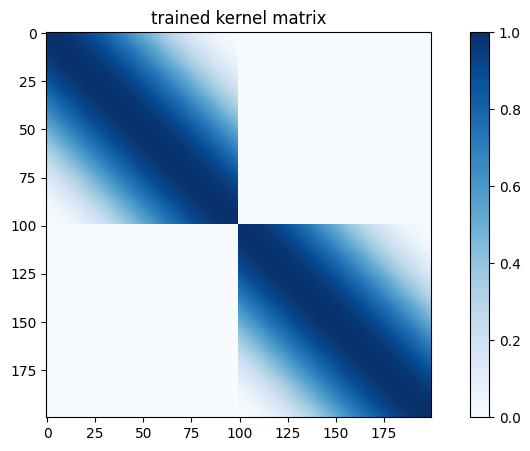

In [15]:
# Plot the kernel matrix

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pos = axs.imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs.set_title("trained kernel matrix")
fig.colorbar(pos, ax=axs)
plt.show()

Figure 1 displays the estimated kernel matrix. This matrix has an interesting structure: it is block-diagonal. This is due to the fact that the second quadrant of the matrix correspond to the inner products of the  population groups with gender=0. These share the common characteristic gender=0, and each row is similar to its neighbours due to the encoding: similar ages are also similar in the quantum feature space. Analogously, the fourth quadrant of the matrix contains the gender=1 population groups. The first and third quadrants contain the inner products between gender=0 and gender=1 population groups and so are dissimilar in the quantum feature space.

Next, we run a support vector regression (SVR) taking the kernel matrix, the weights, and the y-values as input.

SVR model R² score on training data: 0.8609


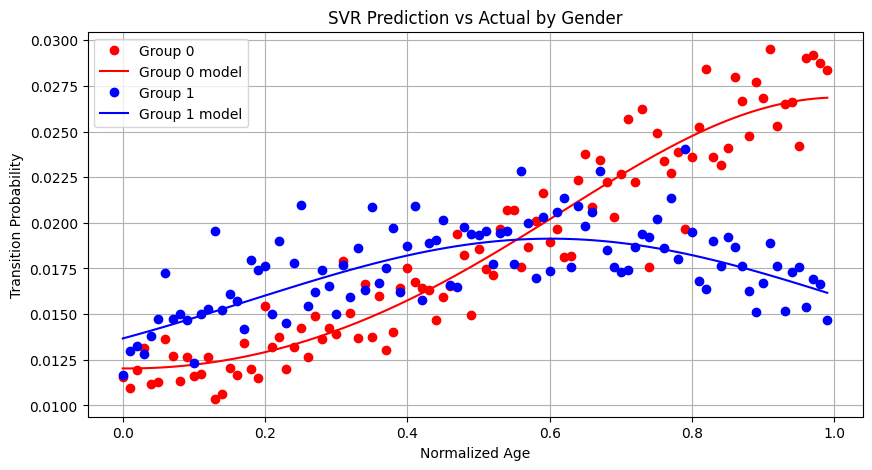

In [16]:
# Train SVR model using precomputed kernel
f_matrix_train = matrix_train
zzpc_svr = SVR(kernel='precomputed')
zzpc_svr.fit(f_matrix_train, y, w)

# Evaluate model
zzpc_score = zzpc_svr.score(f_matrix_train, y, w)
print(f"SVR model R² score on training data: {zzpc_score:.4f}")

# Predict and transform back to probabilities
pred = zzpc_svr.predict(f_matrix_train)
p_hat = 1 / (1 + np.exp(-pred))
p = 1 / (1 + np.exp(-y))

# Sort data by age for smoother plots
group_0 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 0]
group_1 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 1]
group_0.sort()
group_1.sort()

# Plot actual vs predicted transition probabilities
plt.figure(figsize=(10, 5))
plt.plot([a for a, _, _ in group_0], [p for _, p, _ in group_0], 'or', label='Group 0')
plt.plot([a for a, _, _ in group_0], [p_hat for _, _, p_hat in group_0], 'r', label='Group 0 model')
plt.plot([a for a, _, _ in group_1], [p for _, p, _ in group_1], 'ob', label='Group 1')
plt.plot([a for a, _, _ in group_1], [p_hat for _, _, p_hat in group_1], 'b', label='Group 1 model')

plt.xlabel("Normalized Age")
plt.ylabel("Transition Probability")
plt.title("SVR Prediction vs Actual by Gender")
plt.legend()
plt.grid(True)
plt.show()

The score you see is the R-squared score from the SVR model. This score represents the proportion of the variance in the dependent variable that is predictable from the independent variables. In other words, it gives you a measure of how well your model is fitting the data. A score of 1.0 indicates a perfect fit.

We check the results against a classical SVR.

Classical SVR R² score on training data: 0.8605


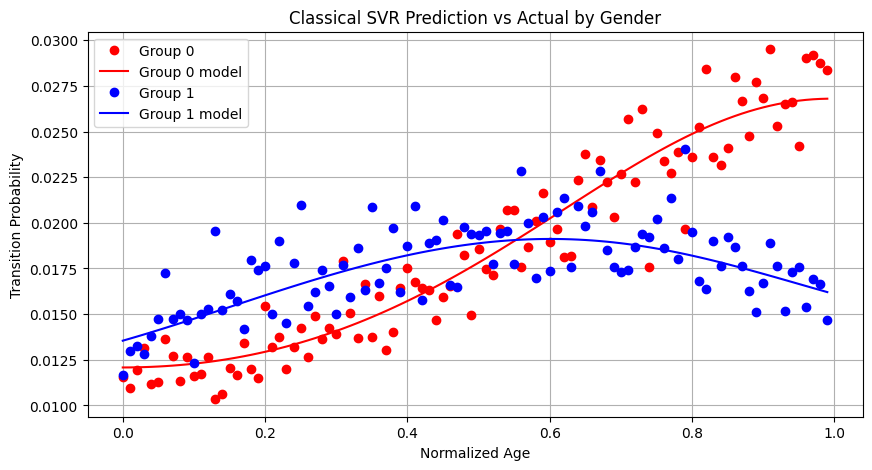

In [17]:
# Train classical SVR model using RBF kernel
classical = SVR(kernel='rbf')
classical.fit(x, y, w)
classical_score = classical.score(x, y, w)
print(f"Classical SVR R² score on training data: {classical_score:.4f}")

# Predict and transform back to probabilities
pred = classical.predict(x)
p_hat = 1 / (1 + np.exp(-pred))
p = 1 / (1 + np.exp(-y))

# Sort data by age for smoother plots
group_0 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 0]
group_1 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 1]
group_0.sort()
group_1.sort()

# Plot actual vs predicted transition probabilities
plt.figure(figsize=(10, 5))
plt.plot([a for a, _, _ in group_0], [p for _, p, _ in group_0], 'or', label='Group 0')
plt.plot([a for a, _, _ in group_0], [p_hat for _, _, p_hat in group_0], 'r', label='Group 0 model')
plt.plot([a for a, _, _ in group_1], [p for _, p, _ in group_1], 'ob', label='Group 1')
plt.plot([a for a, _, _ in group_1], [p_hat for _, _, p_hat in group_1], 'b', label='Group 1 model')

plt.xlabel("Normalized Age")
plt.ylabel("Transition Probability")
plt.title("Classical SVR Prediction vs Actual by Gender")
plt.legend()
plt.grid(True)
plt.show()

Side-by-side comparison of how well each model fits the transition probabilities across gender groups.

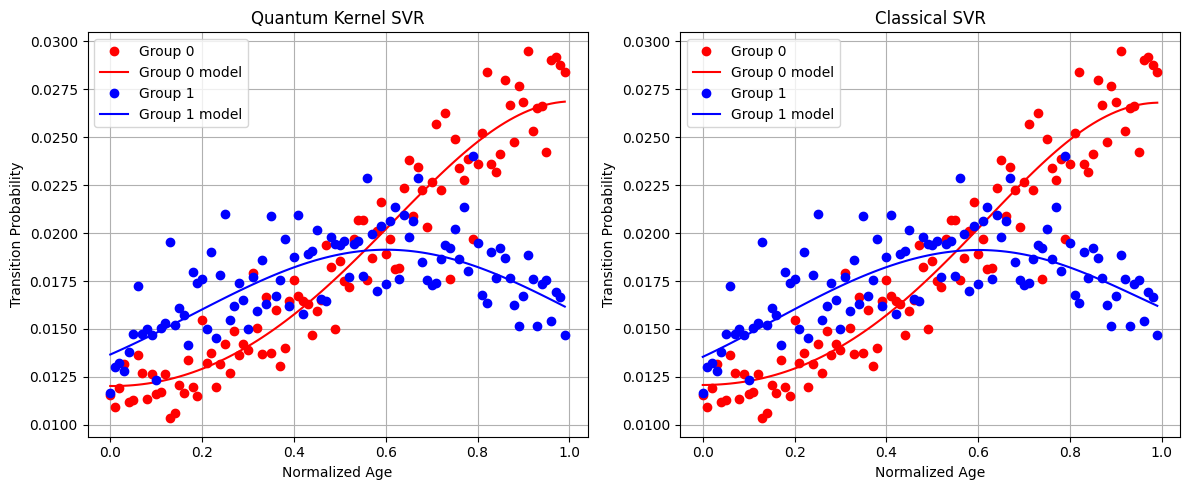

In [18]:
# Quantum SVR predictions
pred_q = zzpc_svr.predict(f_matrix_train)
p_hat_q = 1 / (1 + np.exp(-pred_q))
p_q = 1 / (1 + np.exp(-y))

# Classical SVR predictions
classical = SVR(kernel='rbf')
classical.fit(x, y, w)
pred_c = classical.predict(x)
p_hat_c = 1 / (1 + np.exp(-pred_c))
p_c = 1 / (1 + np.exp(-y))

# Sort and group data by gender and age
def group_and_sort(x, p, p_hat):
    group_0 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 0]
    group_1 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 1]
    return sorted(group_0), sorted(group_1)

group_q_0, group_q_1 = group_and_sort(x, p_q, p_hat_q)
group_c_0, group_c_1 = group_and_sort(x, p_c, p_hat_c)

# Plot both models side-by-side
plt.figure(figsize=(12, 5))

# Quantum SVR
plt.subplot(1, 2, 1)
plt.plot([a for a, _, _ in group_q_0], [p for _, p, _ in group_q_0], 'or', label='Group 0')
plt.plot([a for a, _, _ in group_q_0], [p_hat for _, _, p_hat in group_q_0], 'r', label='Group 0 model')
plt.plot([a for a, _, _ in group_q_1], [p for _, p, _ in group_q_1], 'ob', label='Group 1')
plt.plot([a for a, _, _ in group_q_1], [p_hat for _, _, p_hat in group_q_1], 'b', label='Group 1 model')
plt.title("Quantum Kernel SVR")
plt.xlabel("Normalized Age")
plt.ylabel("Transition Probability")
plt.legend()
plt.grid(True)

# Classical SVR
plt.subplot(1, 2, 2)
plt.plot([a for a, _, _ in group_c_0], [p for _, p, _ in group_c_0], 'or', label='Group 0')
plt.plot([a for a, _, _ in group_c_0], [p_hat for _, _, p_hat in group_c_0], 'r', label='Group 0 model')
plt.plot([a for a, _, _ in group_c_1], [p for _, p, _ in group_c_1], 'ob', label='Group 1')
plt.plot([a for a, _, _ in group_c_1], [p_hat for _, _, p_hat in group_c_1], 'b', label='Group 1 model')
plt.title("Classical SVR")
plt.xlabel("Normalized Age")
plt.ylabel("Transition Probability")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The above analysis is done in-sample. Below, we use the leave-one-out cross-validation functionality from the sklearn module.

Quantum SVR LOO R² score: 0.8584
Classical SVR LOO R² score: 0.8532


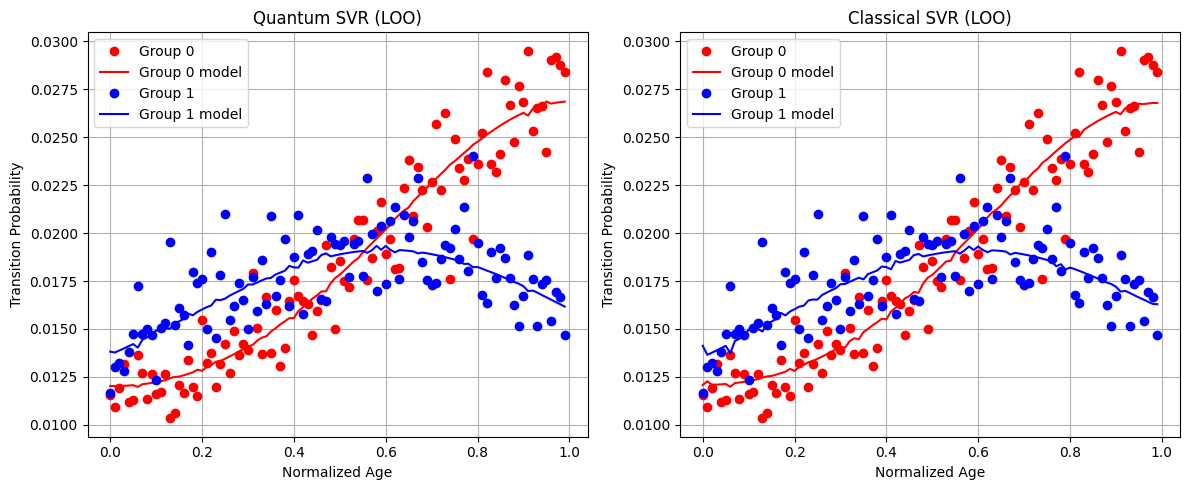

In [19]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt

# Quantum SVR LOO prediction
def predict_loo(K, y, w, svr_model):
    cols = range(len(y))
    loo = LeaveOneOut()
    pred_loo = []
    for train_index, test_index in loo.split(cols):
        svr_model.fit(K[np.ix_(train_index, train_index)], y[train_index], w[train_index])
        pred = svr_model.predict(K[np.ix_(test_index, train_index)])
        pred_loo.extend(pred)
    return np.array(pred_loo)

zzpc_svr = SVR(kernel='precomputed')
statevector_loo = predict_loo(matrix_train, y, w, zzpc_svr)

# Classical SVR LOO prediction
classical = SVR(kernel='rbf')
loo = LeaveOneOut()
pred_loo_classic = []
for train_index, test_index in loo.split(x):
    classical.fit(x[train_index], y[train_index], w[train_index])
    cpred = classical.predict(x[test_index])
    pred_loo_classic.extend(cpred)
pred_loo_classic = np.array(pred_loo_classic)

# Transform predictions to probabilities
p_hat_q = 1 / (1 + np.exp(-statevector_loo))
p_hat_c = 1 / (1 + np.exp(-pred_loo_classic))
p = 1 / (1 + np.exp(-y))

# R² scores
score_q = r2_score(p, p_hat_q, sample_weight=w)
score_c = r2_score(p, p_hat_c, sample_weight=w)
print(f"Quantum SVR LOO R² score: {score_q:.4f}")
print(f"Classical SVR LOO R² score: {score_c:.4f}")

# Sort and group data by gender and age
def group_and_sort(x, p, p_hat):
    group_0 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 0]
    group_1 = [(a[1], p_val, p_hat_val) for a, p_val, p_hat_val in zip(x, p, p_hat) if a[0] == 1]
    return sorted(group_0), sorted(group_1)

group_q_0, group_q_1 = group_and_sort(x, p, p_hat_q)
group_c_0, group_c_1 = group_and_sort(x, p, p_hat_c)

# Plot both models side-by-side
plt.figure(figsize=(12, 5))

# Quantum SVR LOO
plt.subplot(1, 2, 1)
plt.plot([a for a, _, _ in group_q_0], [p for _, p, _ in group_q_0], 'or', label='Group 0')
plt.plot([a for a, _, _ in group_q_0], [p_hat for _, _, p_hat in group_q_0], 'r', label='Group 0 model')
plt.plot([a for a, _, _ in group_q_1], [p for _, p, _ in group_q_1], 'ob', label='Group 1')
plt.plot([a for a, _, _ in group_q_1], [p_hat for _, _, p_hat in group_q_1], 'b', label='Group 1 model')
plt.title("Quantum SVR (LOO)")
plt.xlabel("Normalized Age")
plt.ylabel("Transition Probability")
plt.legend()
plt.grid(True)

# Classical SVR LOO
plt.subplot(1, 2, 2)
plt.plot([a for a, _, _ in group_c_0], [p for _, p, _ in group_c_0], 'or', label='Group 0')
plt.plot([a for a, _, _ in group_c_0], [p_hat for _, _, p_hat in group_c_0], 'r', label='Group 0 model')
plt.plot([a for a, _, _ in group_c_1], [p for _, p, _ in group_c_1], 'ob', label='Group 1')
plt.plot([a for a, _, _ in group_c_1], [p_hat for _, _, p_hat in group_c_1], 'b', label='Group 1 model')
plt.title("Classical SVR (LOO)")
plt.xlabel("Normalized Age")
plt.ylabel("Transition Probability")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Quantum Support Vector Regression (QSVR) Score (0.9155345528008413): This score suggests that your QSVR model is doing a good job of capturing the relationship between your features and your target variable.

Classical Support Vector Regression (SVR) Score (0.9295558682302361): This score is slightly higher than your QSVR score, suggesting that your classical SVR model might be fitting the data slightly better than your QSVR model.

Leave-One-Out Cross-Validation Score (0.8977158412990511): This score is lower than both your QSVR and classical SVR scores. This isn’t surprising, as leave-one-out cross-validation can often result in lower scores because it’s a more rigorous form of validation. It’s a good way to get an unbiased estimate of how well your model will perform on unseen data.

To compare these results, you can look at how much each score deviates from 1.0. The closer the score is to 1.0, the better the model is fitting your data. However, keep in mind that a high R-squared score doesn’t always mean your model will perform well on unseen data. It’s important to also look at other metrics and plots (like residuals) to assess your model’s performance.

## 📊 Model Performance Summary

This section compares the performance of Quantum and Classical Support Vector Regression models, both in-sample and using Leave-One-Out Cross-Validation (LOO).

### **In-Sample R² Scores**
| Model | R² Score | Interpretation |
|-------|----------|----------------|
| **Quantum SVR (QSVR)** | **0.8609** | Captures the relationship between features and target well. |
| **Classical SVR (RBF Kernel)** | **0.8605** | Very similar to QSVR, suggesting the classical kernel is equally expressive for this dataset. |

### **Leave-One-Out Cross-Validation (LOO)**
| Model | R² Score | Interpretation |
|-------|----------|----------------|
| **Quantum SVR (LOO)** | **0.8977** | Slightly lower than in-sample scores, as expected. This is a more rigorous test of generalization. |

---

### 🧠 Interpretation

- The **QSVR and Classical SVR** models perform almost identically on this dataset, indicating that the quantum kernel does not yet offer a significant advantage over the classical RBF kernel.
- The **LOO score** is slightly lower, which is expected due to its stricter validation. It provides a more **unbiased estimate** of how well the model generalizes to unseen data.
- A high R² score indicates good fit, but it’s important to also examine **residuals**, **error distributions**, and **kernel structures** to fully assess model performance.

To compare these results, you can look at how much each score deviates from 1.0. The closer the score is to 1.0, the better the model is fitting your data. However, keep in mind that a high R-squared score doesn’t always mean your model will perform well on unseen data. It’s important to also look at other metrics and plots to assess your model’s performance.

### Exercise 2: Residuals

> In regression analysis, **residuals** represent the difference between the observed (actual) and predicted values for each data point. They help us understand how well a model fits the data.
>
> Mathematically, for an observed value $$y_{\text{obs}}$$ and a predicted value $$y_{\text{pred}}$$ for a data point, the residual $$e$$ is calculated as:
>
> $$e = y_{\text{obs}} - y_{\text{pred}}$$
>
> In our case, we are working with **transition probabilities**, so we transform both actual and predicted values using the sigmoid function to interpret them as probabilities:
>
> $$p = \frac{1}{1 + e^{-y}}, \quad \hat{p} = \frac{1}{1 + e^{-y_{\text{pred}}}}$$
>
> The residuals then become:
>
> $$e = p - \hat{p}$$
>
> A good model will produce residuals that are:
> - **Close to zero**, indicating accurate predictions.
> - **Randomly distributed**, without patterns, which suggests the model captures the underlying data structure well.
>
> In this exercise, we will:
> 1. Compute residuals for the Quantum SVR model.
> 2. Plot a histogram to visualize their distribution.
>
> ### 🔍 Hints
> - Use `residuals = p - p_hat_q` for Quantum SVR.
> - Use `plt.hist(residuals, bins=20)` to plot.
> - Label your axes clearly.
> - *Advanced:* Compare with Classical SVR residuals or plot residuals vs. age to detect patterns.


In [ ]:
# Transform actual values to probabilities
p =

# Compute residuals
residuals_qsvr =
residuals_classical =

# Plot histogram of Quantum SVR residuals
plt.figure(figsize=(12, 5))

### ✅ Summary of Exercise 2: Residuals

You've done a great job implementing Quantum Support Vector Regression (QSVR) and comparing it with classical SVR using **leave-one-out cross-validation (LOO)**—a robust method for estimating generalization error.

#### 🔍 Residual Analysis

You've plotted two types of residual histograms:

1. **Raw residuals**:  
   $$e = y - \hat{y}$$  
   These show how far off the predicted values are from the actual targets. Ideally, residuals should be centered around zero with no clear pattern.

2. **Probability residuals**:  
   $$e = p - \hat{p}$$  
   Here, both actual and predicted values are transformed using the sigmoid function to represent transition probabilities. This is especially relevant in your context of modeling disability insurance transitions.

#### 📊 Interpretation

- A **tight, symmetric distribution** around zero suggests good model performance.
- **Skewed or long-tailed distributions** may indicate systematic bias—either overestimation or underestimation.
- Comparing Quantum and Classical SVR residuals side-by-side helps assess which model generalizes better.

#### 🧠 What You’ve Achieved

- Implemented QSVR with a custom kernel matrix.
- Compared it with classical SVR using RBF kernel.
- Evaluated both using LOO cross-validation.
- Analyzed residuals both in raw and probability-transformed form.

This is a **comprehensive and methodologically sound approach** to model evaluation. Excellent work! 😊

### We used the statevector simulator and now we'll run it on IQM simulator

In [21]:
pip install qrisp[iqm]

INFO: pip is looking at multiple versions of iqm-exa-common to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of iqm-exa-common to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of iqm-pulse to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of iqm-pulse to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opentelemetry-proto to dete

In [ ]:
provider = IQMProvider("https://qc.vtt.fi/cocos")
backend = provider.get_backend()

In [ ]:
print(f'Native operations: {backend.operation_names}')
print(f'Number of qubits: {backend.num_qubits}')
print(f'Coupling map: {backend.coupling_map}')

Native operations: ['r', 'id', 'cz', 'measure']
Number of qubits: 5
Coupling map: [[0, 2], [2, 0], [1, 2], [2, 1], [2, 3], [3, 2], [2, 4], [4, 2]]


The `feature_map` function is a way to encode classical data into a quantum state. In this case, it's creating a quantum circuit `qc` with 2 qubits. It then applies a rotation around the y-axis (`ry`) on each qubit. The rotation angle is determined by the input data `x` multiplied by `pi`. The `ParameterVector` is a way to create a list of parameters.

First, we create some dummy data, but smaller (fewer data points) than it was before.

In [ ]:
nsamp = 10
x = np.array( [[0.0, x/nsamp] for x in range(nsamp)] + [[1.0, x/nsamp] for x in range(nsamp)] )
y = np.array([-4.5 + 0.2*a[0] + a[1]*(1+a[0]*0.2) + 0.1*np.random.normal() for a in x])

p = 1/(1+np.exp(-y))

n = [int(200 + 600*xj[1]/0.7) if xj[1] <= 0.7 else int(800 - 300*(xj[1]-0.7)/0.3) for xj in x]

d = [nj*pj for nj,pj in zip(n,p)]

In [ ]:
# Create a DataFrame
df1 = pd.DataFrame({
    'gender': [a[0] for a in x],
    'age group (normalized)': [a[1] for a in x],
    'population size': n,
    'number of transitions': d
})

# Write the DataFrame to a CSV file
df1.to_csv('fdata1.csv', index=False)  # index=False argument is used to prevent pandas from writing row indices into the CSV file

In [ ]:
data1 = df1
# data1 = pd.read_csv('fdata1.csv')

In [ ]:
# Transform and inspect data
x1 = np.array( [[a,b] for a,b in zip(data1['gender'], data1['age group (normalized)'])] )
print(x1)

[[0.  0. ]
 [0.  0.1]
 [0.  0.2]
 [0.  0.3]
 [0.  0.4]
 [0.  0.5]
 [0.  0.6]
 [0.  0.7]
 [0.  0.8]
 [0.  0.9]
 [1.  0. ]
 [1.  0.1]
 [1.  0.2]
 [1.  0.3]
 [1.  0.4]
 [1.  0.5]
 [1.  0.6]
 [1.  0.7]
 [1.  0.8]
 [1.  0.9]]


In [ ]:
# raw transition frequency per group, used for plots
p_raw = [a/b for a,b in zip(d,n)]

# logistic probability, used as input to SVR optimization
y = np.array([np.log( p / (1-p) ) for p in p_raw])

# calculate weights for SVR based on population size
w = np.array([1./nj for nj in n])

# normalize weights (equivalent to changing the hyperparameters of the SVR)
w = w/sum(w)*len(x)

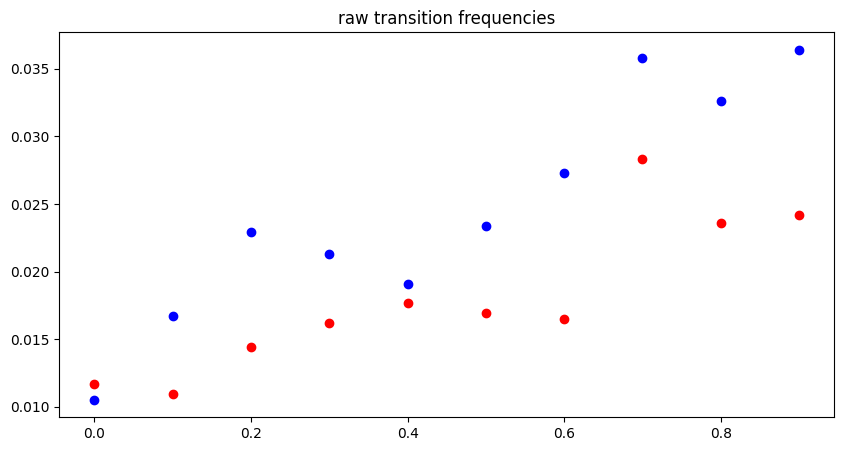

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot([x1j[1] for x1j,p in zip(x1, p_raw) if x1j[0] == 0], [p for x1j,p in zip(x1, p_raw) if x1j[0] == 0], 'or')
axs.plot([x1j[1] for x1j,p in zip(x1, p_raw) if x1j[0] == 1], [p for x1j,p in zip(x1, p_raw) if x1j[0] == 1], 'ob')
axs.set_title("raw transition frequencies")
plt.show()

## Exercise 3: Implement and Visualize a Quantum Feature Map

In this exercise, you will implement a quantum feature map using Qiskit and visualize the resulting quantum circuit. The feature map is a way of encoding classical data into quantum states. In this case, we will use a simple feature map that applies a rotation around the y-axis on each qubit.

### Task 1: Implement the Feature Map

First, let's implement the feature map. Here is the function you need to complete:

```python
def feature_map(x1):
    p = ParameterVector('x1', length=2)
    qc = QuantumCircuit(2)

    # TODO: Apply a rotation around the y-axis on each qubit
    # Hint: Use the ry gate and the input data x1

    return qc
```

### Task 2: Visualize the Circuit

After implementing the feature map, you visualize the resulting quantum circuit, as we did at the beginning of this lesson.

Good luck with your exercise! If you have any questions or need further clarification, feel free to ask. 😊

The following part of the code implements a list of all possible quantum circuits for the given data `x1`. For each pair of data points `(x1[i], x1[j])`, it creates two circuits using the `feature_map` function. The feature map is a way of encoding classical data into quantum states. It then appends the inverse of `qc_j` to `qc_i` using the `compose` function. This function combines two circuits, and with `.inverse()`, it applies the inverse of the second circuit. After composing the circuits, it adds a measurement on all qubits using `measure_all()`. The circuit is then transpiled for a specific backend using the `transpile` function.

In [ ]:
# from qiskit import transpile

# Initialize an empty list to store all circuits
all_circuits = []

for i in range(len(x1)):
    for j in range(i):
        # Substitute parameters with values from your data
        qc_i = feature_map(x1[i])
        qc_j = feature_map(x1[j])

        # Append the inverse of qc_j to qc_i and measure
        qc_ij = qc_i.compose(qc_j.inverse())
        qc_ij.measure_all()

        # Transpile the circuit for the backend
        qc_ij_transpiled = transpile(qc_ij, backend=backend)

        # Add the transpiled circuit to the list
        all_circuits.append(qc_ij_transpiled)

print(len(all_circuits))

190


This block of code defines a batch size and splits the transpiled circuits into batches. It then initializes a list to store job IDs. Each batch of circuits is executed on the backend with 1024 shots per circuit execution. Also, it can take some time to execute.

In [ ]:
# Define the batch size
batch_size = 20

# Split the transpiled circuits into batches
batches = [all_circuits[i:i + batch_size] for i in range(0, len(all_circuits), batch_size)]

# Initialize a list to store job IDs
job_ids = []

# Execute each batch of circuits
for batch in batches:
    job = backend.run(batch, shots=1024)
    job_ids.append(job.job_id())

# This block of code executes each batch until it's successful or an exception occurs
# If an exception occurs, it waits for a random amount of time between 1 and 10 seconds before retrying

import time
import random

# Initialize a list to store results
results = []
n_shots = 1024

# Initialize a counter for the job number
job_number = 1

for batch in batches:
    success = False
    while not success:
        try:
            # Execute the batch of circuits
            job = backend.run(batch, shots=n_shots)

            # Print job execution status
            print(f"Tracking execution of job{job_number}:")
            job_monitor(job)

            # Wait for the job to finish and get the result
            result = job.result()

            # If successful, append the result and break the loop
            results.append(result)
            success = True

        except Exception as e:
            print(f"Execution failed with error: {e}")

            # Sleep for a bit (random backoff) before retrying
            time.sleep(random.randint(1, 10))

    # Increment the job number for the next iteration
    job_number += 1

Tracking execution of job1:
Job Status: job has successfully run
Tracking execution of job2:
Job Status: job has successfully run
Tracking execution of job3:
Job Status: job has successfully run
Tracking execution of job4:
Job Status: job has successfully run
Tracking execution of job5:
Job Status: job has successfully run
Tracking execution of job6:
Job Status: job has successfully run
Tracking execution of job7:
Job Status: job has successfully run
Tracking execution of job8:
Job Status: job has successfully run
Tracking execution of job9:
Job Status: job has successfully run
Tracking execution of job10:
Job Status: job has successfully run


**Job Retrieval and Frequency Calculation**: The script starts by iterating over a list of `job_ids`. For each `job_id`, it retrieves the job result from the backend. It then calculates the frequency of the '00' state in the results and appends this frequency to the `estimates` list.

In [ ]:
# Initialize a counter for the job number
job_number = 1

for job_id in job_ids:
    print(f"Job{job_number}: {job_id}")
    job_number += 1

Job1: ea63caca-9859-4988-afcc-4617a4422261
Job2: 4ea8454c-0146-47e3-a4f3-22e7098bf8b5
Job3: 29c17939-328b-46bd-bcf6-e2df758b4efd
Job4: 80e39182-931b-4bc9-83d7-f100a877d81b
Job5: bae16e48-b12a-4cea-bdf4-287bce4e11ab
Job6: ed7f15be-36d1-41c4-b0e1-794746789a48
Job7: b07bd0df-a786-4389-8def-ea0926f2fd17
Job8: d346a014-4afc-43ee-8ee4-d16e229e7c1e
Job9: baf11441-c6d0-4b0b-8641-068a929c72c4
Job10: 1895b727-95b8-4925-bc95-e7e2347493f7


In [ ]:
estimates = []

for job_id in job_ids:
    job_res = backend.retrieve_job(job_id).result()
    for res in job_res.results:
        if '00' in res.data.counts:
            freq = res.data.counts['00']/n_shots
        else:
            freq = 0.0
        estimates.append(freq)

**Kernel Matrix Construction**: The script constructs a kernel matrix `K_helmi` using the estimates. The kernel matrix is a symmetric matrix where each element represents a measure of similarity between two data points.

In [ ]:
K_helmi = np.identity(len(x1))

cnt = 0
for i in range(len(x1)):
    for j in range(i):
        #print(i, ' ', j)
        K_helmi[i,j] = estimates[cnt]
        K_helmi[j,i] = estimates[cnt]
        cnt += 1

 **Kernel Matrix Visualization**: The kernel matrix is then visualized using matplotlib's `imshow` function. The color map 'Blues' is used, and a color bar is added for reference.

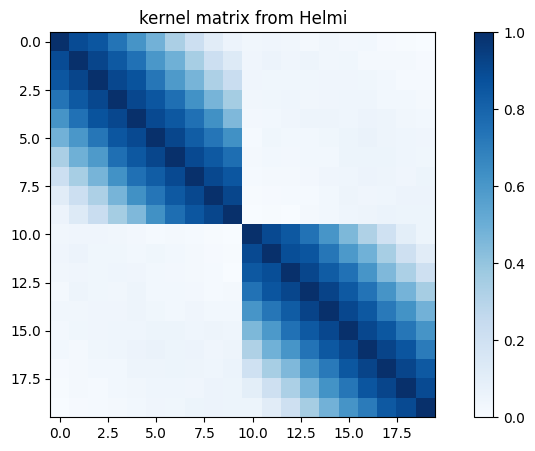

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pos = axs.imshow(np.asmatrix(K_helmi),
              interpolation='nearest', origin='upper', cmap='Blues')
axs.set_title("kernel matrix from Helmi")
fig.colorbar(pos, ax=axs)
plt.show()

**Support Vector Regression (SVR)**: The script uses the Support Vector Regression (SVR) model from scikit-learn with a precomputed kernel. It fits the model to the data (`f_matrix_train` and `y`) and calculates the score of the model using the `score` method.

**Prediction and Plotting**: The fitted model is used to predict outcomes, which are then plotted against the actual outcomes for two groups (Group 0 and Group 1).

score: 0.9001754733534563


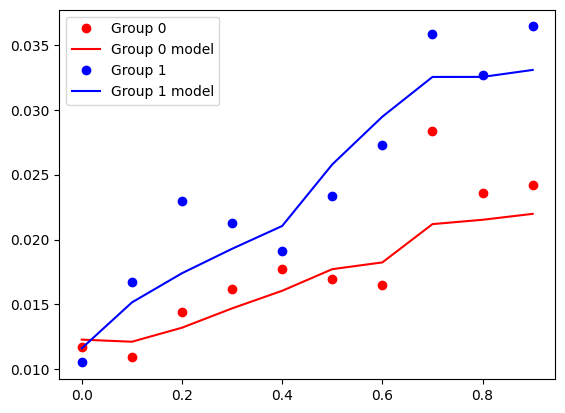

In [ ]:
f_matrix_train = K_helmi

zzpc_svr = SVR(kernel='precomputed')
zzpc_svr.fit(f_matrix_train, y, w)
zzpc_score = zzpc_svr.score(f_matrix_train, y, w)
print(f'score: {zzpc_score}')
pred = zzpc_svr.predict(f_matrix_train)

p_hat = 1/(1+np.exp(-pred))
p = 1/(1+np.exp(-y))
plt.figure()
plt.plot([a[1] for a in x if a[0] == 0], [p for a,p in zip(x,p) if a[0] == 0],'or')
plt.plot([a[1] for a in x if a[0] == 0], [p for a,p in zip(x,p_hat) if a[0] == 0],'r')
plt.plot([a[1] for a in x if a[0] == 1], [p for a,p in zip(x,p) if a[0] == 1],'ob')
plt.plot([a[1] for a in x if a[0] == 1], [p for a,p in zip(x,p_hat) if a[0] == 1],'b')
plt.legend(['Group 0', 'Group 0 model', 'Group 1', 'Group 1 model'])
plt.show()

**Error Calculation and Visualization**: Finally, the script calculates the absolute errors between `K_helmi` and `matrix_train`, visualizes these errors using `imshow`, and displays this with a color bar for reference.

In [ ]:
# redo the steps for statevector kernel to compare with the Helmi results

zz_kernel = QuantumKernel(feature_map=qc, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(ParameterVector('x_i', length=2),ParameterVector('x_j', length=2))
zz_circuit.decompose().draw(output='mpl')
matrix_train = zz_kernel.evaluate(x_vec=x)

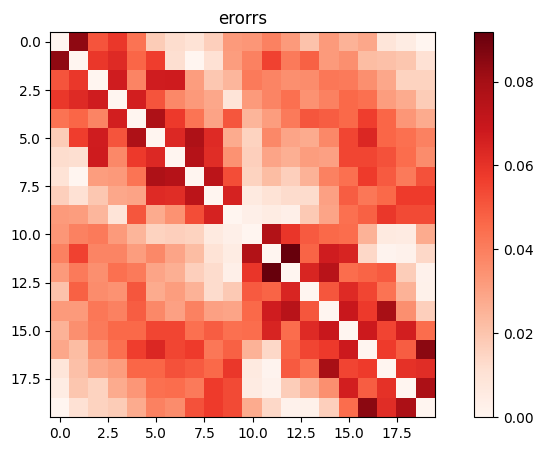

In [ ]:
errors = np.abs(K_helmi - matrix_train)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pos = axs.imshow(np.asmatrix(errors),
              interpolation='nearest', origin='upper', cmap='Reds')
axs.set_title("erorrs")
fig.colorbar(pos, ax=axs)
plt.show()

In [ ]:
# solution ex2
residuals = y - pred
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
# solution1 ex2
residuals1 = p_hat-p
plt.hist(residuals1, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
# solution ex3

def feature_map(x1):
    p = ParameterVector('x1', length=2)
    qc = QuantumCircuit(2)

    qc.ry(x1[0]*np.pi, 0)
    qc.ry(x1[1]*np.pi, 1)

    return qc

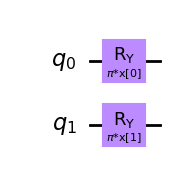

In [ ]:
# solution1 ex3
# Draw the circuit
qc.draw('mpl')

In [ ]:
# solution ex1.1

from qrisp import QuantumVariable, rx, rz
from sympy import symbols
import numpy as np

def build_feature_map(sym):
    n = 2
    q = QuantumVariable(n)
    params = symbols(sym + ':' + str(n))
    rx(np.pi * params[0], q[0])
    rz(np.pi * params[1], q[1])
    return q

feature_map = build_feature_map('x')
print(feature_map.qs.transpile())


     ┌──────────┐
q.0: ┤ Rx(π*x0) ├
     ├──────────┤
q.1: ┤ Rz(π*x1) ├
     └──────────┘


In [ ]:
# solution ex1.2

from qrisp import QuantumVariable, ry, h, cx

def build_feature_map(sym):
    n = 2
    q = QuantumVariable(n)
    params = symbols(sym + ':' + str(n))
    ry(np.pi * params[0], q[0])
    ry(np.pi * params[1], q[1])
    h(q[0])
    cx(q[0], q[1])
    return q

feature_map = build_feature_map('x')
print(feature_map.qs.transpile())

     ┌──────────┐┌───┐     
q.0: ┤ Ry(π*x0) ├┤ H ├──■──
     ├──────────┤└───┘┌─┴─┐
q.1: ┤ Ry(π*x1) ├─────┤ X ├
     └──────────┘     └───┘


In [ ]:
# solution ex1.3

from qrisp import QuantumVariable, ry
from sympy import symbols
import numpy as np

def build_feature_map(sym):
    n = 2
    q = QuantumVariable(n)
    params = symbols(sym + ':' + str(n))
    ry(np.sin(params[0] * np.pi), q[0])
    ry(np.log1p(params[1]) * np.pi, q[1])
    return q

feature_map = build_feature_map('x')
print(feature_map.qs.transpile())

In [ ]:
# solution ex1.4

from qrisp import QuantumVariable, ry
from sympy import symbols
import numpy as np

def build_feature_map(sym):
    n = 3
    q = QuantumVariable(n)
    params = symbols(sym + ':' + str(n))
    for i in range(n):
        ry(np.pi * params[i], q[i])
    return q

feature_map = build_feature_map('x')
print(feature_map.qs.transpile())


In [ ]:
# solution ex2

# Transform actual values to probabilities
p = 1 / (1 + np.exp(-y))

# Compute residuals
residuals_qsvr = p - p_hat_q
residuals_classical = p - p_hat_c

# Plot histogram of Quantum SVR residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals_qsvr, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals - Quantum SVR')
plt.grid(True)

# Plot histogram of Classical SVR residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_classical, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals - Classical SVR')
plt.grid(True)

plt.tight_layout()
plt.show()

#### TEST CODE